# Проверка гипотез для увеличения выручки крупного интернет-магазина. Запуск A/B-теста.

**Цель исследования**

Необходимо приоритизировать гипотезы для увеличения выручки интернет-магазина и проанализировать результаты A/B-теста. 

**Описание данных**

Мы будем работать с данными из следующих файлов:
- /datasets/hipothesis.csv,
где:
  - Hypothesis — краткое описание гипотезы;
  - Reach — охват пользователей по 10-балльной шкале;
  - Impact — влияние на пользователей по 10-балльной шкале;
  - Confidence — уверенность в гипотезе по 10-балльной шкале;
  - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
    
- /datasets/orders.csv,
где:
  - transactionId — идентификатор заказа;
  - visitorId — идентификатор пользователя, совершившего заказ;
  - date — дата, когда был совершён заказ;
  - revenue — выручка заказа;
  group — группа A/B-теста, в которую попал заказ.
  
- /datasets/visitors.csv,
где:
  - date — дата;
  - group — группа A/B-теста;
  - visitors — количество пользователей в указанную дату в указанной группе A/B-теста
 
О качестве данных ничего не известно. Поэтому перед исследованием данных понадобится их обзор.

**Ход исследования**

Изучим общую информацию о датасетах. Что можно сказать о каждом столбце? Значения какого типа они хранят? 

Проверим данные на ошибки, и оценим их влияние на исследование, затем, на этапе предобработки, изучим возможность исправить самые критичные ошибки в данных.

Далее проведем необходимые вычисления, на основании которых проанализируем данные и, таким образом, исследование пройдёт в 5 этапов:

- [Загрузка и базовый анализ данных.](#1)
- [Предобработка данных.](#2)
- [Приоритизация гипотез.](#3)
- [Анализ результатов A/B-теста.](#4)
- [Общий вывод.](#5)

## Загрузка и обзор данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from scipy import stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Форматируем таблицу так, чтобы строки с большим количеством текста выводились польностью
pd.options.display.max_colwidth = 150

In [3]:
# Чтение файлов
path1 = '/Users/marina/CSV_files/hypothesis.csv'
path2 = '/Users/marina/CSV_files/orders.csv'
path3 = '/Users/marina/CSV_files/visitors.csv'

if os.path.exists(path1):
    hypothesis = pd.read_csv(path1)
    
if os.path.exists(path2):
    orders = pd.read_csv(path2)    

if os.path.exists(path3):
    visitors = pd.read_csv(path3)    

else:
    print('Something is wrong')

In [4]:
# Выводим основную информацию по датасету hypothesis
display(hypothesis.head(10))
print()
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В датасете hypothesis 5 столбцов, 9 строк.

Согласно документации к данным:
1. Hypothesis — краткое описание гипотезы;
2. Reach — охват пользователей по 10-балльной шкале;
3. Impact — влияние на пользователей по 10-балльной шкале;
4. Confidence — уверенность в гипотезе по 10-балльной шкале;
5. Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

С типами данных в столбцах все в порядке. Неплохо было бы привести названия столбцов к нижнему регистру.

In [5]:
# Выводим основную информацию по датасету orders
display(orders.head())
print()
orders.info()
print()
# Выводим описание количественных данных в столбце revenue
display(orders['revenue'].describe())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB



count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

В датасете orders 5 столбцов, 1197 строк.

Согласно документации к данным:
1. transactionId — идентификатор заказа;
2. visitorId — идентификатор пользователя, совершившего заказ;
3. date — дата, когда был совершён заказ;
4. revenue — выручка заказа;
5. group — группа A/B-теста, в которую попал заказ.

В стобце date необходимо поменять тип данных на datetime. Названия стобцов transactionId и visitorId необходимо привести к единому формату.

Стандартное отклонение сильно отличается от среднего, наверняка в данных есть аномалии.

In [6]:
# Выводим основную информацию по датасету visitors
display(visitors.head())
print()
visitors.info()
print()
# Выводим описание количественных данных в столбцах visitors
display(visitors['visitors'].describe())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB



count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

В датасете visitors 3 столбца, 62 строки.

Согласно документации к данным:
1. date — дата;
2. group — группа A/B-теста;
3. visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

В стобце date необходимо поменять тип данных на datetime.
Стандартное отклонение также сильно отличается от среднего, необходимо это учесть для проверки на аномалии.

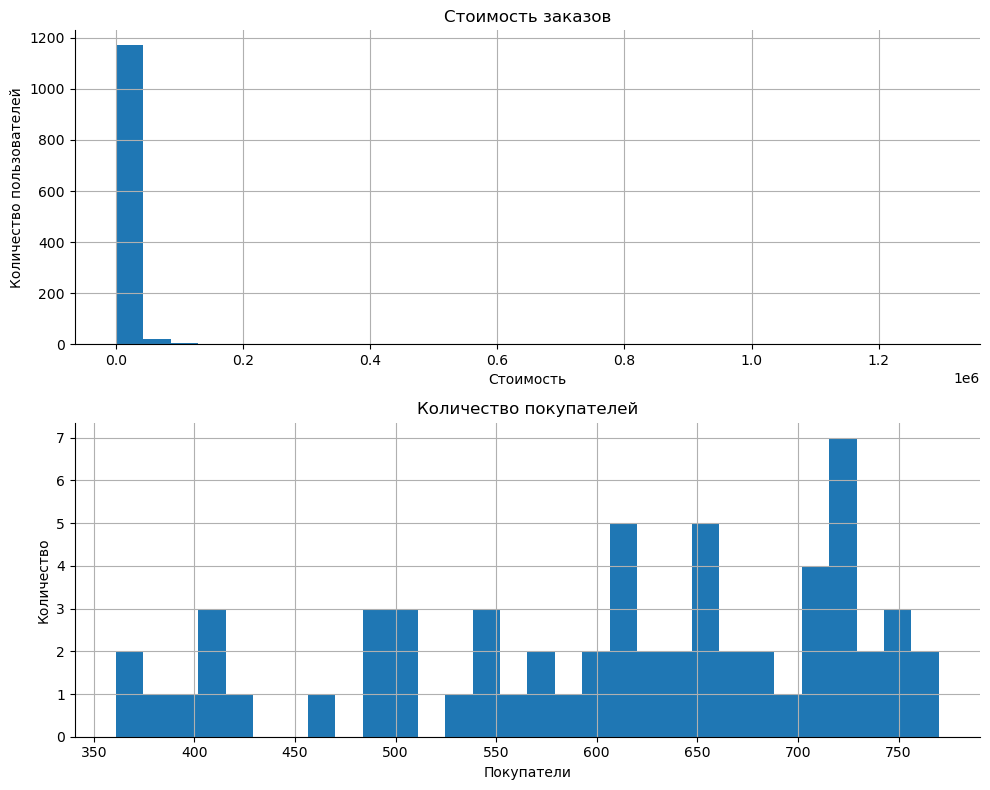

In [7]:
# Построим гистограммы для количественных столбцов датасетов orders и visitors

# Задаем размер графиков
plt.figure(figsize=(10, 8)) 

orders['revenue'].hist(bins=30, ax=plt.subplot(2,1,1))
plt.xlabel('Стоимость')
plt.ylabel('Количество пользователей')
plt.title('Стоимость заказов')

visitors['visitors'].hist(bins=30, ax=plt.subplot(2,1,2))
plt.xlabel('Покупатели')
plt.ylabel('Количество')
plt.title('Количество покупателей')

sns.despine()
plt.tight_layout()

plt.show()

На гистограммах мы видим, что основная масса значений стоблца revenue датасета orders лежит в интервале до 50 тыс. руб. В стобце visitors датасета visitors присутствуют явные аномалии (нулевые значения между 420 и 460 посетителями , и выброс после 700).

**Выводы:**

На данном этапе мы:
- Прочитали файлы с данными;
- Вывели и изучили общую информацию о них;

Впереди предобработка данных.

<a id="2"></a>

## Предобработка данных

### Преобразуем типы данных, где необходимо

In [8]:
orders['date'] = pd.to_datetime(orders['date'])

In [9]:
visitors['date'] = pd.to_datetime(visitors['date'])

### Преобразуем названия стобцов, где необходимо

In [10]:
hypothesis.columns = hypothesis.columns.str.lower()

In [11]:
orders = orders.rename(columns={'transactionId':'transaction_id',
                        'visitorId':'visitor_id'})

### Проверим пропуски в датасетах

In [12]:
# Создадим копии датасетов до преобразований
temp = hypothesis.copy() 
len(temp)

9

In [13]:
temp1 = orders.copy() 
len(temp1)

1197

In [14]:
temp2 = visitors.copy() 
len(temp2)

62

In [15]:
# Выведем количество пропущенных значений для датасета hypothesis и отсортируем по возрастанию.
hypothesis.isna().sum().sort_values()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

In [16]:
# Выведем количество пропущенных значений для датасета orders и отсортируем по возрастанию.
orders.isna().sum().sort_values()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

In [17]:
# Выведем количество пропущенных значений для датасета visitors и отсортируем по возрастанию.
visitors.isna().sum().sort_values()

date        0
group       0
visitors    0
dtype: int64

Пропусков данных в датасетах нет.

### Проверим дубликаты в датасетах orders и visitors

In [18]:
# Напишем функцию для проверки данных на наличие явных дубликатов
def find_explicit_duplicates(dataset):
    
    # Находим явные дубликаты
    explicit_duplicates_cnt = display(f'Количество явных дубликатов: {dataset.duplicated().sum()}')
    
    explicit_duplicates = None
    explicit_duplicates_cnt = 0
    
    if dataset.duplicated().sum() > 0:
        explicit_duplicates = display(dataset[dataset.duplicated(keep=False)])
    
    else:
        display('Явные дубликаты не найдены')
    
    return explicit_duplicates_cnt, explicit_duplicates

In [19]:
# Проверим явные дубликаты в датасете orders
dataset = orders.copy()
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

In [20]:
# Проверим явные дубликаты в датасете visitors
dataset = visitors.copy()
find_explicit_duplicates(dataset)

'Количество явных дубликатов: 0'

'Явные дубликаты не найдены'

(0, None)

В датасетах orders и visitors явные дубликаты не найдены.

In [21]:
# Напишем функцию для проверки данных на наличие неявных дубликатов
def find_implicit_duplicates(dataset, columns_to_compare):
    
    # Находим неявные дубликаты
    implicit_duplicates = dataset[dataset.duplicated(subset=columns_to_compare, keep=False)]
    if implicit_duplicates.empty:
        display('Неявных дубликатов нет.')
  
    return implicit_duplicates

In [22]:
# Проверим датасет orders на наличие неявных дубликатов
dataset = orders.copy()
columns_to_compare = ['transaction_id']
find_implicit_duplicates(dataset, columns_to_compare)

'Неявных дубликатов нет.'

,transaction_id,visitor_id,date,revenue,group


In [23]:
dataset = orders.copy()
columns_to_compare = ['visitor_id']
find_implicit_duplicates(dataset, columns_to_compare)

,transaction_id,visitor_id,date,revenue,group
2,2961555356,4069496402,2019-08-15,400,A
15,2550768810,2742574263,2019-08-15,15277,B
20,2904772834,963407295,2019-08-15,300,B
23,4252514150,351125977,2019-08-15,15185,B
24,1162046357,3234906277,2019-08-15,7555,B
...,...,...,...,...,...
1182,2682156369,1668030113,2019-08-14,1290,B
1183,1458356232,963407295,2019-08-14,4940,A
1184,1329499668,2949041841,2019-08-14,10380,B
1189,4082620617,393266494,2019-08-14,31550,B


В датасете orders найдены неявные дубликаты в столбце visitor_id. Вероятно покупатели заходили несколько раз в период проведения теста. Посмотрим выборочно на эти строки.

In [24]:
orders.query('visitor_id == 2742574263')

,transaction_id,visitor_id,date,revenue,group
15,2550768810,2742574263,2019-08-15,15277,B
91,3176574859,2742574263,2019-08-22,17868,B
840,234238251,2742574263,2019-08-21,9448,B


In [25]:
orders.query('visitor_id == 199603092')

,transaction_id,visitor_id,date,revenue,group
26,2223239646,199603092,2019-08-15,3488,A
134,62794304,199603092,2019-08-22,6976,A
246,437656952,199603092,2019-08-02,3488,B
823,2971973105,199603092,2019-08-27,2790,A
1102,1941707234,199603092,2019-08-12,6438,A


In [26]:
orders.query('visitor_id == 393266494')

,transaction_id,visitor_id,date,revenue,group
525,3031564664,393266494,2019-08-19,21550,A
936,936917445,393266494,2019-08-08,2190,B
1189,4082620617,393266494,2019-08-14,31550,B


Итак, что мы видим. Некоторые покупатели за время проведения теста заходили несколько раз на сайт. Часть из них попала в одну и ту же группу, как и должно быть, а часть в разные, что неправильно. Таких покупателей нужно удалить, чтобы они не искажали результаты теста, их поведение «поломано» и на них замерить эффект будет очень сложно.

In [27]:
# Сгруппируем данные по visitor_id, отфильтруем их по group и оставим в датасете orders только те строки, 
# где уникальное значение group для одинаковых visitor_id одно
orders = orders.groupby('visitor_id').filter(lambda x: len(x['group'].unique()) == 1)

In [28]:
# Проверим датасет visitors на наличие неявных дубликатов
dataset = visitors.copy()
columns_to_compare = ['visitors']
find_implicit_duplicates(dataset, columns_to_compare)

,date,group,visitors
7,2019-08-08,A,610
10,2019-08-11,A,718
29,2019-08-30,A,490
38,2019-08-08,B,654
39,2019-08-09,B,610
58,2019-08-28,B,654
60,2019-08-30,B,490
61,2019-08-31,B,718


Тут также есть неявные дубликаты. Три покупателя попали в разные группы во время разных входов на сайт. В visitors у нас агрегированная информация, а не информация на уровне одного пользователя, поэтому наличие дубликатов в связке "день-группа-посетители" хоть и необычная, но всё же может иметь место быть, поэтому оставляем как есть.

### Проверим уникальные значения в датасетах orders и visitors

In [29]:
# Напишем функцию, которая будет выводить описание данных в столбце, уникальные значения и их количество
def unique_describe(dataset):
    return  display(dataset.describe(), len(dataset.unique())), print(sorted(dataset.unique())) 

Проверим уникальные значения в датасете orders

In [30]:
dataset = orders['transaction_id']
unique_describe(dataset)

count    1.016000e+03
mean     2.155085e+09
std      1.234372e+09
min      1.062393e+06
25%      1.143481e+09
50%      2.144499e+09
75%      3.256513e+09
max      4.288552e+09
Name: transaction_id, dtype: float64

1016

[1062393, 4919758, 7210578, 8131427, 11068804, 19446369, 19467429, 26423654, 29438557, 31060183, 35929812, 38478481, 42506358, 50225499, 50573571, 51443164, 52260954, 55417546, 69312188, 70327311, 86411600, 86504917, 90109939, 96707201, 123992977, 125335873, 128480032, 133616433, 141445646, 142712712, 143829018, 151437276, 154338469, 158295218, 160345536, 161113724, 165288431, 175321713, 175363373, 177293476, 178265899, 180749850, 181836088, 182168103, 194489498, 198999602, 202241000, 210558688, 212815314, 217480737, 218256919, 218467446, 225225498, 231209528, 234238251, 235474681, 237002862, 260086319, 262925486, 264388722, 271768864, 287313500, 290089453, 290380159, 290471249, 290974848, 297844270, 298049028, 298049448, 305846010, 310029418, 316924019, 318597867, 323958042, 324018163, 324171086, 335158381, 339489775, 348143148, 352861950, 364342391, 365058890, 369801982, 373945924, 374969414, 375844049, 376170286, 380504587, 380685964, 383287370, 384670583, 390467479, 393610987, 3948

(None, None)

В стобце transaction_id ничего не обычного не замечаю.

In [31]:
dataset = orders['visitor_id'].copy()
unique_describe(dataset)

count    1.016000e+03
mean     2.128677e+09
std      1.221578e+09
min      5.114589e+06
25%      1.043655e+09
50%      2.150274e+09
75%      3.146991e+09
max      4.283872e+09
Name: visitor_id, dtype: float64

973

[5114589, 6958315, 11685486, 39475350, 47206413, 48147722, 54447517, 56960363, 66685450, 71018815, 78678012, 78758296, 85103373, 87885904, 91069833, 102981183, 104602633, 109615108, 113298937, 114507418, 117599621, 130417038, 132143192, 134926050, 138252163, 148427295, 151496413, 152397976, 154576532, 154825609, 157579733, 162423694, 171459513, 172218683, 178249104, 179951984, 181166394, 182753106, 184835319, 187589092, 191870721, 194969263, 195530970, 199874245, 201615765, 204675465, 206724078, 222718357, 228221722, 233773277, 235366767, 236764260, 238992583, 243620413, 248503091, 249864742, 252987601, 258610743, 259989552, 264456202, 266115224, 274717519, 277405052, 280073872, 281523083, 282188993, 284094220, 285030828, 290022471, 295230930, 296565978, 300249313, 309675944, 318152663, 321150727, 325179089, 329473477, 329726006, 343208965, 352377175, 358944393, 363280180, 366673373, 367176526, 368204224, 368679516, 370388673, 381340408, 382846391, 387170777, 392419518, 399216493, 3994

(None, None)

С учетом удаления неявных дубликатов ранее, с данными все в порядке.

In [32]:
dataset = orders['revenue'].copy()
unique_describe(dataset)

count    1.016000e+03
mean     8.300815e+03
std      4.212199e+04
min      5.000000e+01
25%      1.190000e+03
50%      2.955000e+03
75%      8.134250e+03
max      1.294500e+06
Name: revenue, dtype: float64

631

[50, 60, 70, 75, 76, 90, 100, 110, 112, 120, 130, 150, 160, 165, 170, 172, 190, 240, 250, 265, 270, 282, 290, 295, 299, 300, 320, 340, 350, 359, 360, 370, 380, 382, 383, 390, 400, 410, 420, 426, 436, 440, 450, 460, 470, 490, 495, 500, 510, 530, 540, 550, 570, 580, 590, 599, 600, 604, 610, 620, 632, 640, 650, 654, 660, 690, 697, 700, 720, 725, 730, 740, 750, 760, 770, 778, 780, 785, 790, 800, 820, 830, 840, 850, 870, 880, 890, 900, 910, 920, 950, 971, 985, 987, 990, 995, 1000, 1020, 1038, 1040, 1044, 1050, 1060, 1090, 1100, 1120, 1130, 1139, 1140, 1149, 1170, 1180, 1188, 1190, 1200, 1220, 1250, 1253, 1290, 1310, 1320, 1329, 1350, 1380, 1390, 1398, 1399, 1410, 1420, 1435, 1440, 1450, 1460, 1490, 1498, 1510, 1530, 1540, 1575, 1590, 1600, 1620, 1630, 1634, 1640, 1650, 1680, 1690, 1707, 1710, 1720, 1721, 1729, 1730, 1737, 1758, 1780, 1790, 1799, 1800, 1805, 1825, 1830, 1840, 1846, 1850, 1855, 1860, 1870, 1885, 1893, 1900, 1910, 1920, 1940, 1950, 1960, 1980, 1990, 1993, 1999, 2000, 2030, 205

(None, None)

In [33]:
dataset = orders['group'].copy()
unique_describe(dataset)

count     1016
unique       2
top          B
freq       548
Name: group, dtype: object

2

['A', 'B']


(None, None)

В стобцах revenue и group ничего необычного.

Проверим уникальные значения датасета visitors.

In [34]:
dataset = visitors['visitors'].copy()
unique_describe(dataset)

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

58

[361, 369, 378, 395, 406, 412, 413, 421, 468, 487, 490, 502, 507, 509, 531, 543, 544, 546, 560, 575, 577, 581, 594, 595, 609, 610, 617, 619, 621, 628, 644, 646, 650, 654, 655, 656, 667, 668, 676, 679, 699, 707, 709, 711, 713, 717, 718, 719, 720, 721, 722, 735, 737, 746, 748, 756, 769, 770]


(None, None)

In [35]:
dataset = visitors['group'].copy()
unique_describe(dataset)

count     62
unique     2
top        A
freq      31
Name: group, dtype: object

2

['A', 'B']


(None, None)

В стобцах visitors и group визуально в порядке с уникальными значениями.

In [36]:
# Сверяем наши данные по количеству строк по окончанию обработки данных в датасетах
a, b = len(temp), len(hypothesis)
print(len(temp), len(hypothesis), round((a - b) / a * 100, 2))

9 9 0.0


In [37]:
a, b = len(temp1), len(orders)
print(len(temp1), len(orders), round((a - b) / a * 100, 2))

1197 1016 15.12


In [38]:
a, b = len(temp2), len(visitors)
print(len(temp2), len(visitors), round((a - b) / a * 100, 2))

62 62 0.0


### Определим временной интервал данных

In [39]:
# Найдем минимальную и максимальную даты в orders
display(f'Минимальная дата поездки: {orders["date"].min()}')
display(f'Максимальная дата поездки: {orders["date"].max()}')

'Минимальная дата поездки: 2019-08-01 00:00:00'

'Максимальная дата поездки: 2019-08-31 00:00:00'

In [40]:
# Найдем минимальную и максимальную даты в visitors
display(f'Минимальная дата поездки: {visitors["date"].min()}')
display(f'Максимальная дата поездки: {visitors["date"].max()}')

'Минимальная дата поездки: 2019-08-01 00:00:00'

'Максимальная дата поездки: 2019-08-31 00:00:00'

В исследование попали данные с 8 августа 2019 года по 31 августа 2019 года.

**Выводы:**

На данном этапе мы:
- преобразовали тип данных в столбцах date датасетов orders и visitors на datetime;
- проверили данные во всех датасетах на пропуски, они не обнаружены;
- проверили данные на явные дубликаты, не обнаружили их;
- проверили данные на неявные дубликаты. Удалили в датасетах orders и visitors тех покупателей, которые несколько раз посещали сайт в период тестирования и почему-то попали в разные группы;
- изучили уникальные значения в датасете orders и visitors, не нашли ничего необычного.
- выяснили, что период анализа у нас с 01-08-2019 по 31-08-2019.

<a id="3"></a>

## Приоритизация гипотез

Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, необходимо приоритизировать сформулированные гипотезы. Воспользуемся одним из самых популярных способов приоритизации задач ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота»). У этого метода есть модификация RICE (R от англ. reach, «охват»). Их отличие в том, что RICE учитывает скольких пользователей затронет изменение, которое мы хотим внести. ICE от RICE отличается также легкостью и быстротой в расчетах.
Приритизируем наши гипотезы обоими методами и проанализируем результат.

In [41]:
hypothesis['id'] = np.arange(len(hypothesis))[::1]+1
hypothesis

,hypothesis,reach,impact,confidence,efforts,id
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,1
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,5
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,6
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,7
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,8
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,9


Мы видим список из 9 гипотез, каждый параметр которых оценен по шкале от 0 до 10.

In [42]:
# Применим фреймворк ICE для приоритизации гипотез. Отсортируем результат по убыванию приоритета
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']),2)
hypothesis[['id', 'hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,id,hypothesis,ICE
8,9,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,2,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE имеют следующие id: 9, 1, 8, 7, 3

In [43]:
# Применим фреймворк RICE для приоритизации гипотез. Отсортируем результат по убыванию приоритета
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] /  \
                     hypothesis['efforts']), 2)
hypothesis[['id', 'hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,id,hypothesis,RICE
7,8,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,3,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,7,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,9,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,4,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,2,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,5,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по RICE имеют id: 8, 3, 1, 7, 9

Мы видим в топ-5 одни и те же гипотезы, но их приоритизация изменилась. 9ая и 3ья гипотезы поменялись местами. Так произошло потому,  что у гипотезы 3 reach равен 8, а у 9ой - 1, 3ья затронет гораздо больше пользователей, чем 9ая. У 8ой гипотезы, которая вышла на первое место, самый высокий охват пользователей - 10, высокая степень уверености и влияния на пользователей. У 1 и 7 гипотез, также высокая степень уверенности.

**Выводы:**

На данном этапе мы приоритизировали гипотезы методами ICE и RICE.

Следует в первую очередь обратить внимание на следующие гипотезы:
- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
  
Если необходимо принять во внимание охват пользователей, то ранжирование будет следующее:

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
- Запустить акцию, дающую скидку на товар в день рождения.   

<a id="4"></a>

## Анализ A/B-теста

Результаты проведения A/B-теста хранятся в датсетах orders и visitors. Проанализируем их. Перед началом анализа сравним размер выборок.

In [44]:
# Посчитаем количество покупателей из группы A и группы B, а также насколько эти выборки отличаются
print('Количество покупателей (группа A):',
      round(orders.query('group == "A"')['visitor_id'].nunique()/orders['visitor_id'].nunique()*100, 2),'%')
print('Количество покупателей (группа B):', 
      round(orders.query('group == "B"')['visitor_id'].nunique()/orders['visitor_id'].nunique()*100, 2),'%')
print('Разница:', round(orders.query('group == "A"')['visitor_id'].nunique()/orders['visitor_id'].nunique()*100 - \
                  orders.query('group == "B"')['visitor_id'].nunique()/orders['visitor_id'].nunique()*100, 2),'%')

Количество покупателей (группа A): 45.73 %
Количество покупателей (группа B): 54.27 %
Разница: -8.53 %


Vы видим, что наши выборки распределены неравномерно. Группа А у нас получается на 8,53% меньше группы B. Тут тем не менее важно отметить, что не столько важен сам баланс пользователей между группами, а достижение группами нужного количества участников теста для обеспечения требуемой статистической мощности нашего теста. Этот размер группы обычно высчитывается с помощью специальных калькуляторов на этапе проектирования А/В теста.

### График кумулятивной выручки по группам

In [45]:
# Создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates() 

In [46]:
# Получаем агрегированные кумулятивные по дням данные о заказах
orders_agg = dates_groups.apply(lambda x: orders[np.logical_and(
                                orders['date'] <= x['date'], 
                                orders['group'] == x['group'])].agg({
                                                                     'date' : 'max', 
                                                                     'group' : 'max', 
                                                                     'transaction_id' : 'nunique', 
                                                                     'visitor_id' : 'nunique', 
                                                                     'revenue' : 'sum'
                                                                    }), axis=1).sort_values(by=['date','group'])

In [47]:
# Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_agg = dates_groups.apply(lambda x: visitors[np.logical_and(
                                  visitors['date'] <= x['date'], 
                                  visitors['group'] == x['group'])].agg({
                                                                         'date' : 'max', 
                                                                         'group' : 'max', 
                                                                         'visitors' : 'sum'
                                                                        }), axis=1).sort_values(by=['date','group'])

In [48]:
# Объединяем кумулятивные данные в одной таблице
unite_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
unite_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
unite_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [49]:
# Сделаем срез с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
unite_revenue_A = unite_data.query('group == "A"')[['date','revenue', 'orders']]
unite_revenue_A.head()

,date,revenue,orders
0,2019-08-01,142779,23
2,2019-08-02,234381,42
4,2019-08-03,346854,66
6,2019-08-04,388030,77
8,2019-08-05,474413,99


In [50]:
# Сделаем срез с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
unite_revenue_B = unite_data.query('group == "B"')[['date','revenue', 'orders']]
unite_revenue_B.head()

,date,revenue,orders
1,2019-08-01,59758,17
3,2019-08-02,221801,40
5,2019-08-03,288850,54
7,2019-08-04,385740,68
9,2019-08-05,475648,89


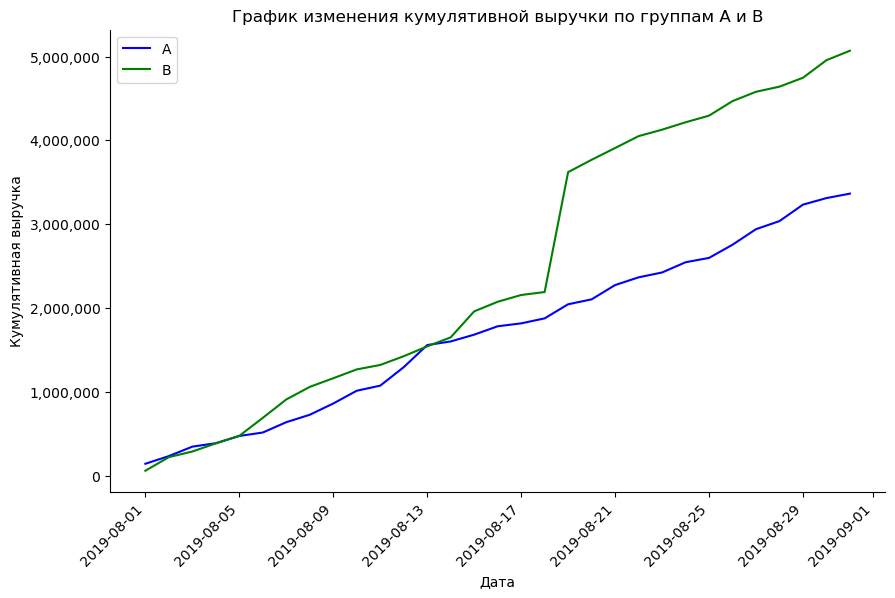

In [51]:
# Задаем размер графиков
plt.figure(figsize=(10, 6)) 

# Строим график выручки группы А
sns.lineplot(data=unite_revenue_A,  x='date', y='revenue', 
             color='blue', linestyle='-', label='A')

# Строим график выручки группы B
sns.lineplot(data=unite_revenue_B,  x='date', y='revenue', 
             color='green', linestyle='-', label='B')

plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:,.0f}'.format(x))
plt.xticks(rotation=45, ha='right')
plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.title('График изменения кумулятивной выручки по группам A и B')
sns.despine()

plt.show()

Выручка в группе А достаточно равномерно увеличивается на протяжении всего теста, это хорошо, но она ниже, чем в группе B. А вот в группе В виден резкий скачок роста выручки 19 августа, после чего рост также стабилизируется. С чем связан этот скачок пока непонятно, может быть число заказов выросло или выручка с одного заказа стала больше. Проверим это.

In [52]:
check1 = orders.groupby('date').agg({'transaction_id':'count', 'revenue':'sum'})
check1

,transaction_id,revenue
date,,
2019-08-01,40,202537
2019-08-02,42,253645
2019-08-03,38,179522
2019-08-04,25,138066
2019-08-05,43,176291
2019-08-06,38,255761
2019-08-07,39,342412
2019-08-08,36,238780
2019-08-09,30,237403


Действительно 19 августа мы видим резкий скачок в сумме выручки - 1598113 руб. Была совершена дорогая покупка.

### График кумулятивного среднего чека по группам

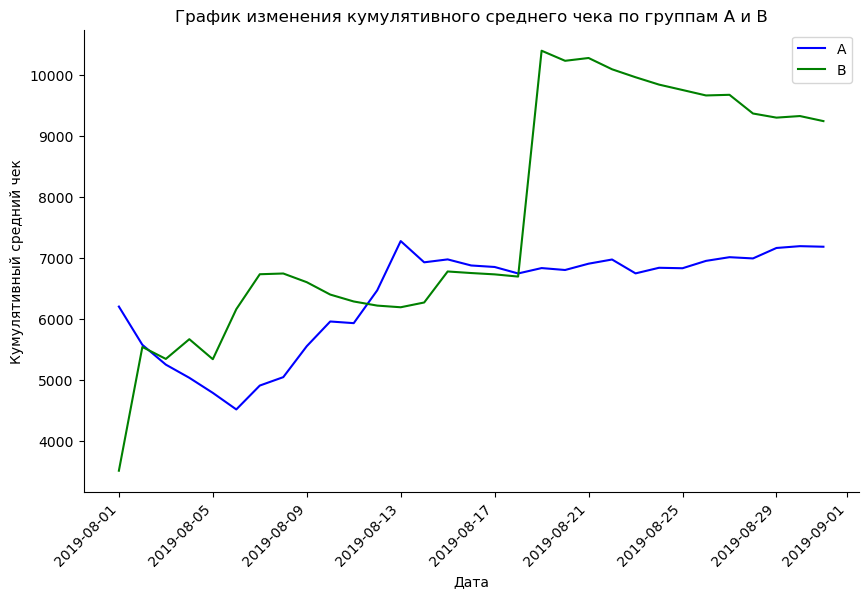

In [53]:
# Задаем размер графиков
plt.figure(figsize=(10, 6)) 

# Строим график среднего чека группы А
sns.lineplot(data=unite_revenue_A,  x='date', y=unite_revenue_A['revenue']/unite_revenue_A['orders'], 
             color='blue', linestyle='-', label='A')

# Строим график среднего чека группы B
sns.lineplot(data=unite_revenue_B,  x='date', y=unite_revenue_B['revenue']/unite_revenue_B['orders'], 
             color='green', linestyle='-', label='B')

plt.xticks(rotation=45, ha='right')
plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.title('График изменения кумулятивного среднего чека по группам A и B')
sns.despine()

plt.show()

Средний чек для группы А установился, начиная с 14 августа. А вот средний чек в группе В совершил скачок 19 августа, после чего мы видим падение. Как мы выяснили выше, такой скачок выручки и среднего чека в группе B все-таки связан с единоразовой крупной покупкой.

### График относительного изменения кумулятивного среднего чека группы B к группе A

In [54]:
# Объединим данные unite_revenue_A и unite_revenue_B
unite_revenue_merged = unite_revenue_A.merge(unite_revenue_B, left_on='date', right_on='date', how='left',
                                          suffixes=['A', 'B'])
unite_revenue_merged.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


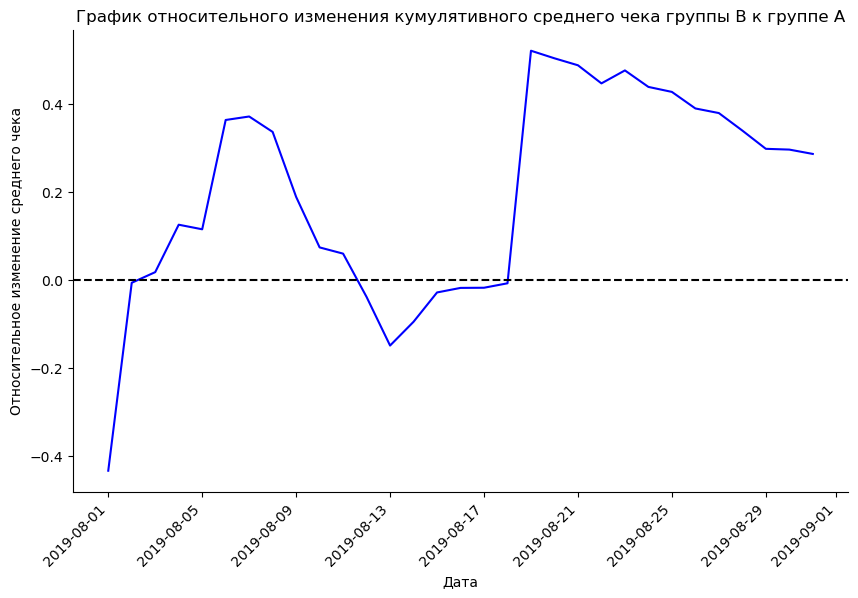

In [55]:
# Задаем размер графика
plt.figure(figsize=(10, 6)) 

# Строим график отношения средних чеков
sns.lineplot(data=unite_revenue_merged ,  x='date', 
             y=((unite_revenue_merged['revenueB']/unite_revenue_merged ['ordersB'])/ \
             (unite_revenue_merged['revenueA']/unite_revenue_merged ['ordersA'])-1), 
             color='blue', linestyle='-')

# Добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.xticks(rotation=45, ha='right')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего чека')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
sns.despine()

plt.show()

6-7 августа и 18 августа график резко возрастает. Вероятно, причина в выбросах, таких как аномально дорогие покупки.

### График  кумулятивного среднего количества заказов на посетителя по  группам

In [56]:
# Добавим в датасет unite_data столбцец conversion, где рассчитаем среднее количество заказов на посетителя
# считаем кумулятивную конверсию
unite_data['conversion'] = unite_data['orders']/unite_data['visitors']
unite_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
1,2019-08-01,B,17,17,59758,713,0.023843
2,2019-08-02,A,42,36,234381,1338,0.031390
3,2019-08-02,B,40,39,221801,1294,0.030912
4,2019-08-03,A,66,60,346854,1845,0.035772


In [57]:
# Сделаем срез по группе A
unite_data_A = unite_data.query('group == "A"')
unite_data_A.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
2,2019-08-02,A,42,36,234381,1338,0.031390
4,2019-08-03,A,66,60,346854,1845,0.035772
6,2019-08-04,A,77,71,388030,2562,0.030055
8,2019-08-05,A,99,92,474413,3318,0.029837


In [58]:
# Сделаем срез по группе B
unite_data_B = unite_data.query('group == "B"')
unite_data_B.head()

,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,17,17,59758,713,0.023843
3,2019-08-02,B,40,39,221801,1294,0.030912
5,2019-08-03,B,54,53,288850,1803,0.029950
7,2019-08-04,B,68,66,385740,2573,0.026428
9,2019-08-05,B,89,87,475648,3280,0.027134


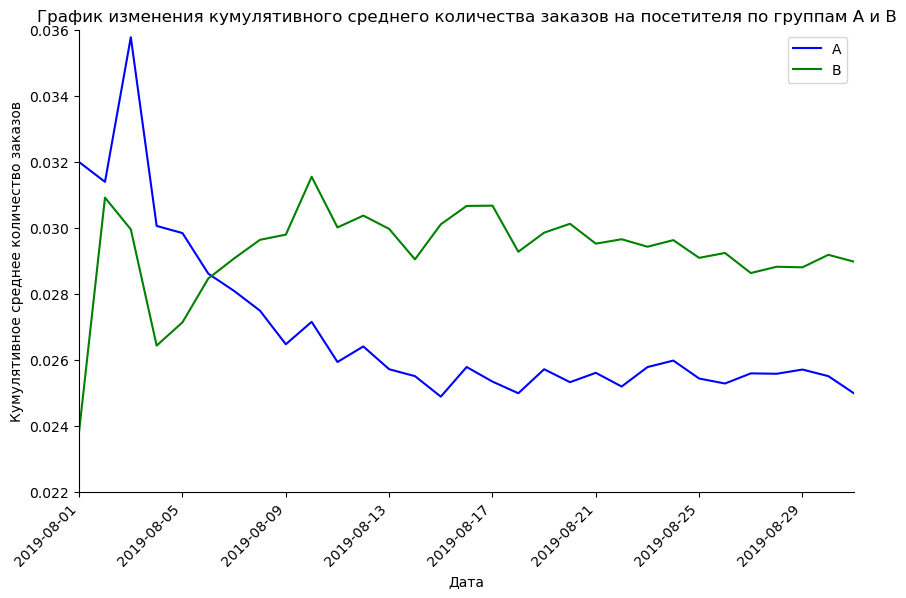

In [59]:
# Задаем размер графиков
plt.figure(figsize=(10, 6)) 

# Строим график среднего количества заказов на посетителя группы А
sns.lineplot(data=unite_data_A,  x='date', y='conversion', 
             color='blue', linestyle='-', label='A')

# Строим график среднего количества заказов на посетителя группы B
sns.lineplot(data=unite_data_B,  x='date', y='conversion', 
             color='green', linestyle='-', label='B')

# Задаем масштаб осей
plt.axis([unite_data_B['date'].min(), unite_data_B['date'].max(), 0.022, 0.036])

plt.xticks(rotation=45, ha='right')
plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов')
plt.title('График изменения кумулятивного среднего количества заказов на посетителя по группам A и B')
sns.despine()

plt.show()

На начальном этапе теста среднее количество покупок на посетителя по группам дало большой рост, причем пики группы B на 1-2 дня опережали пики группы A. Затем к 5 августа мы видим серьезное падение среднего количества заказов. После 15 августа оба графика выровнилясь и среднее количество заказов стабилизировалось. Среднее количество заказов в группе B в целом выше.

### График  относительного изменения кумулятивного среднего количества заказов на посетителя группы A к группе B

In [60]:
# Объединим данные unite_data_A и unite_data_B
unite_data_conversions = unite_data_A[['date','conversion']].merge(unite_data_B[['date','conversion']], 
                                                                   left_on='date', right_on='date', how='left',
                                                                   suffixes=['A', 'B'])
unite_data_conversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


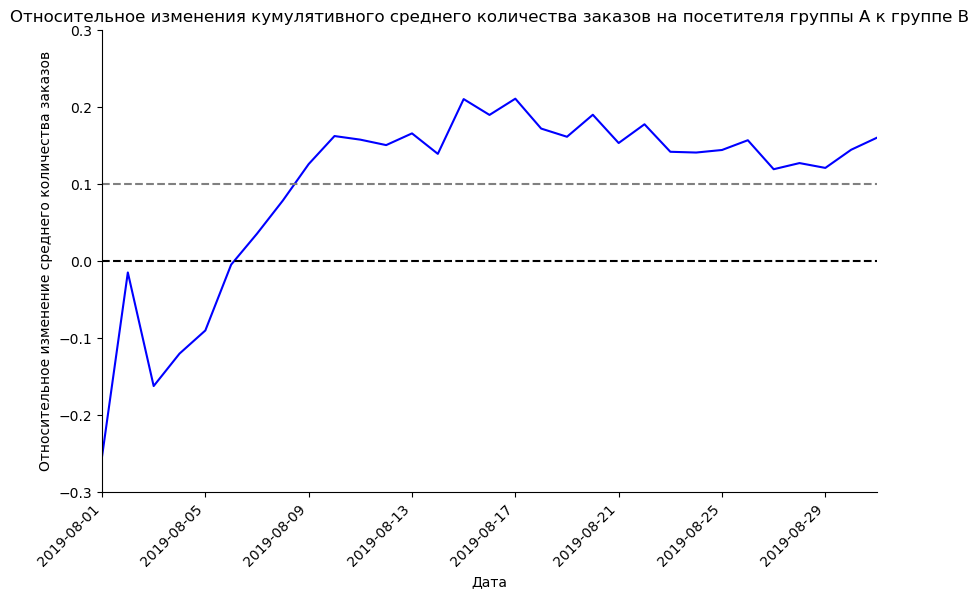

In [61]:
# Задаем размер графикa
plt.figure(figsize=(10, 6)) 

# Строим график среднего количества заказов на посетителя группы А
sns.lineplot(data=unite_data_conversions,  x='date', 
             y=(unite_data_conversions['conversionB']/unite_data_conversions['conversionA']-1), 
             color='blue', linestyle='-')

# Добавляем оси x
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')

# Задаем масштаб осей
plt.axis([unite_data_conversions['date'].min(), unite_data_conversions['date'].max(), -0.3, 0.3])

plt.xticks(rotation=45, ha='right')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего количества заказов')
plt.title('Относительное изменения кумулятивного среднего количества заказов на посетителя группы А к группе B')
sns.despine()

plt.show()

В начале теста относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A скачкообразно росло и падало, снова росло. После 3го августа мы видим резкий скачок вверх. Потом  снова падение, и с 15го августа относительное изменение установилось на примерно одном уровне и к концу периода видна небольшая тенденция к росту. Сейчас выводы делать сложно, необходимо сначала проанализировать аномалии, возможно они изменят или прояснят картину.

### График  количества заказов по пользователям

In [62]:
# Посчитаем количество заказов по пользователям
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})

orders_by_users.columns = ['visitor_id', 'orders']
orders_by_users = orders_by_users.sort_values(by='orders', ascending=False)
orders_by_users.head()

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


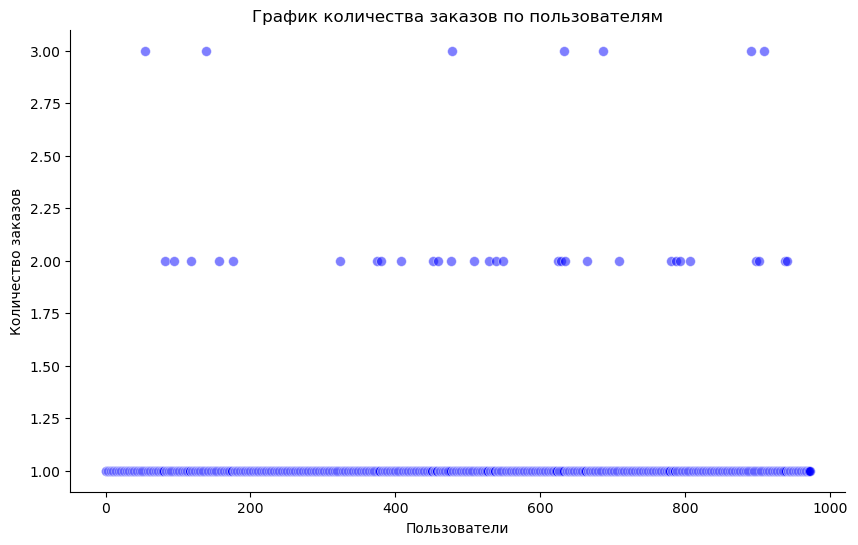

In [63]:
# Построим точечную диаграмму числа заказов на одного пользователя

# Задаем размер графикa
plt.figure(figsize=(10, 6)) 

x_values = pd.Series(range(0,len(orders_by_users)))

sns.scatterplot(data=orders_by_users, y=orders_by_users['orders'], x=x_values, s=50, marker='o', color='blue',
               alpha=0.5)

plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.title('График количества заказов по пользователям')
sns.despine()

plt.show()

Мы видим, что большинство пользователей ограничилось одной покупкой. Некоторые сделали заказ два раза, в единичных случаях - 3 раза. Думаю, что если бы мы не удалили покупателей, которые заходили много раз, но попали в разные группы тестирования, то мы бы увидели единичные большие выбросы.

### 95-й и 99-й перцентили количества заказов на пользователя

In [64]:
# Посчитаем 95-й и 99-й перцентили количества заказов на одного пользователя
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Не более 5% процентов покупателей оформляли больше 1 заказа, и не более 1% оформляли больше 2 заказов. Возьмем за верхнюю границу для определение аномальных пользователей 2 заказа на одного покупателя.

### График стоимостей заказов

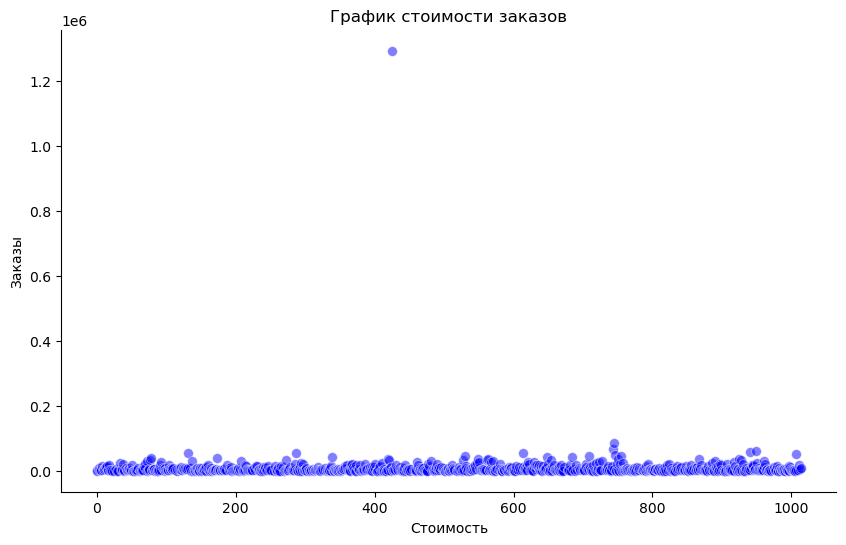

In [65]:
# Построим точечную диаграмму стоимости заказов

# Задаем размер графикa
plt.figure(figsize=(10, 6)) 

x_values = pd.Series(range(0,len(orders['revenue'])))

sns.scatterplot(data=orders, y=orders['revenue'], x=x_values, s=50, marker='o', color='blue', alpha=0.5)

plt.xlabel('Стоимость')
plt.ylabel('Заказы')
plt.title('График стоимости заказов')
sns.despine()

plt.show()

Мы видим один выброс в районе 1 млн. 300 тысяч. руб. Какая-то очень дорогая покупка, видимо, она и вызвала всплеск за графиках кумулятивных метрик. Основная масса стоимостей заказов не превышает 25-30 тыс. рублей, но есть и те, которые стоят до 100 тысяч.

### 95-й и 99-й перцентили стоимости заказов

In [66]:
# Посчитаем 95-й и 99-й перцентили стоимости заказов
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% процентов покупателей оформляли заказ больше чем на 26875 руб., и не более 1% оформляли заказ больше чем на 53904 руб. Возьмем за верхнюю границу для определение аномальных стоимостей заказов  26785 руб.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по "сырым" данным

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя по "сырым" данным, без удаления аномальных пользователей.

Сформулируем гипотезы:

*Нулевая гипотеза (H0):* различий в среднем количестве заказов на посетителя между группами нет.

*Альтернативная гипотеза (H1):* различия в среднем количестве заказов на посетителя между группами есть.

In [67]:
# Создадим переменные orders_by_users_A и orders_by_users_B со столбцами ['visitor_id', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов
orders_by_users_A = (orders.query('group == "A"').groupby('visitor_id', as_index=False).agg({
                                                          'transaction_id': pd.Series.nunique}))
orders_by_users_A.columns = ['visitor_id', 'orders']

orders_by_users_B = (orders.query('group == "B"').groupby('visitor_id', as_index=False).agg({
                                                          'transaction_id': pd.Series.nunique}))

orders_by_users_B.columns = ['visitor_id', 'orders'] 

In [68]:
# Объявим переменные sample_A и sample_B, в которых пользователям из разных групп будет соответствовать 
# количество заказов. Тем, кто ничего не заказал, будут соответствовать нули 
sample_A = pd.concat([orders_by_users_A['orders'], pd.Series(0, index=np.arange(
           visitors.query('group == "A"')['visitors'].sum() - len(orders_by_users_A['orders'])), name='orders',),],
           axis=0,)

sample_B = pd.concat([orders_by_users_B['orders'], pd.Series(0, index=np.arange(
           visitors.query('group == "B"')['visitors'].sum() - len(orders_by_users_B['orders'])), name='orders',),],
           axis=0,)

Для проверки гипотез будем использовать непараметрический тест Уилкоксона-Манна-Уитни, который хорошо подходит для использования, когда в данных есть большие (по сравнению с нормальным распределением) выбросы. Данные интернет-магазина как раз из этой категории, так как данные о продажах и средних чеках редко бывают нормально распределены.

In [69]:
alpha = 0.05 # уровень статистической значимости, если p-value окажется меньше него, то отвергнем гипотезу

result1 = st.mannwhitneyu(sample_A, sample_B)[1]

print('P-value: {0:.3f}'.format(result1))

if result1 < alpha:
    print('Отвергаем нулевую гипотезу. Между группами есть различия в среднем количестве заказов на покупателя')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

result2 = sample_B.mean() / sample_A.mean() - 1

print('Относительное различие группы B к A: {0:.3%}'.format(result2))

P-value: 0.011
Отвергаем нулевую гипотезу. Между группами есть различия в среднем количестве заказов на покупателя
Относительное различие группы B к A: 15.980%


По "cырым" данным различия в среднем количестве заказов на покупателя между группами есть.
P-value составляет 0.011, что меньше 0.05. Отвергаем нулевую гипотезу о том, что между группами нет различий. Относительное различие в пользу группы B составляет 15.98%.

### Статистическая значимость различий в среднем чеке заказа  между группами по "сырым" данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по "сырым" данным, без удаления аномальных пользователей.

Сформулируем гипотезы:

*Нулевая гипотеза (H0):* различий в среднем чеке заказа между группами нет.

*Альтернативная гипотеза (H1):* различия в среднем чеке заказа между группами есть.

Начнем с подготовки данных.

In [70]:
# Рассчитаем статистическую значимость различий в среднем чеке, передав критерию mannwhitneyu() данные о выручке 
# с заказов
alpha = 0.05 # уровень статистической значимости, если p-value окажется меньше него, то отвергнем гипотезу

result3 = st.mannwhitneyu(orders.query('group =="A"')['revenue'], 
                          orders.query('group =="B"')['revenue'])[1]

print('P-value: {0:.3f}'.format(result3))

if result3 < alpha:
    print('Отвергаем нулевую гипотезу. Между группами есть различия в среднем чеке заказов')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

result4 = orders.query('group =="B"')['revenue'].mean() / \
          orders.query('group =="A"')['revenue'].mean() - 1

print('Относительное различие группы B к A: {0:.3%}'.format(result4))

P-value: 0.829
Нет оснований отвергнуть нулевую гипотезу
Относительное различие группы B к A: 28.660%


P-value составляет 0.829, что сильно больше 0.05.
По "cырым" данным у нас нет оснований отвергнуть нулевую гипотезу о том, что между группами нет различий. Но при этом относительное различие среднего чека в пользу группы B составляет 28.7%.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по "очищенным" данным

Примем (как мы уже решили выше) за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 26785. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.  Сделаем срезы пользователей с числом заказов больше 2 — users_with_many_orders и пользователей, совершивших заказы дороже 26785 — users_with_expensive_orders. Объединим их в таблице abnormal_users.
Узнаем, сколько всего аномальных пользователей методом shape().

In [71]:
many_orders = np.percentile(orders_by_users['orders'], 99)

expensive_orders = np.percentile(orders["revenue"], 95)

users_with_many_orders = pd.concat([orders_by_users_A[orders_by_users_A['orders'] > 
                                                      many_orders]['visitor_id'],
                             orders_by_users_B[orders_by_users_B['orders'] 
                                               > many_orders]['visitor_id'],], axis=0,)

users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']

abnormal_users = (pd.concat([users_with_many_orders, users_with_expensive_orders], 
                            axis=0).drop_duplicates().sort_values())

display(abnormal_users.head())
print(abnormal_users.shape[0]) 


568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64

58


58 аномальных пользователей.

In [72]:
# Посчитаем относительные потери пользователй (отношение количества аномальных пользователей к 
#общем количеству пользователей)
customers_losses = round(abnormal_users.shape[0] / orders['visitor_id'].nunique() * 100, 2)
print('Относительная потеря пользователей:', customers_losses, '%')

Относительная потеря пользователей: 5.96 %


Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по "очищенным" данным. 

In [73]:
# Подготовим выборки количества заказов по пользователям по группам теста
sample_filtered_A = pd.concat([orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))]['orders'],
            pd.Series(0, index=np.arange(
            visitors.query('group == "A"')['visitors'].sum() - len(orders_by_users_A['orders'])), name='orders',),], 
                              axis=0,)

sample_filtered_B = pd.concat([orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))]['orders'],
            pd.Series(0, index=np.arange(
            visitors.query('group == "B"')['visitors'].sum() - len(orders_by_users_B['orders'])), name='orders',),], 
                              axis=0,) 

In [74]:
# Применим статистический критерий Манна-Уитни к полученным выборкам

alpha = 0.05 # уровень статистической значимости, если p-value окажется меньше него, то отвергнем гипотезу

result5 = st.mannwhitneyu(sample_filtered_A, sample_filtered_B)[1]

print('P-value: {0:.3f}'.format(result5))

if result5 < alpha:
    print('Отвергаем нулевую гипотезу. Между группами есть различия в среднем количестве заказов по пользователям')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

result6 = sample_filtered_B.mean() / sample_filtered_A.mean() - 1

print('Относительное различие группы B к A: {0:.3%}'.format(result6))

P-value: 0.012
Отвергаем нулевую гипотезу. Между группами есть различия в среднем количестве заказов по пользователям
Относительное различие группы B к A: 18.190%


Результаты по "очищенным" данным несильно отличаются от "сырых". P-value составляет 0.012, что меньше 0.05. Отвергаем нулевую гипотезу о том, что между группами нет различий. Относительное различие в среднем количестве заказов по пользователям в пользу группы B составляет 18.2%, что немного выше, чем по "сырым" данным (15.9%).

### Статистическая значимость различий в среднем чеке заказа  между группами по "очищенным" данным

In [75]:
# Рассчитаем статистическую значимость различий в среднем чеке

alpha = 0.05 # уровень статистической значимости, если p-value окажется меньше него, то отвергнем гипотезу

result7 = st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                            np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'], 
                          orders[np.logical_and(orders['group'] == 'B',
                            np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'],)[1]

print('P-value: {0:.3f}'.format(result7))

if result7 < alpha:
    print('Отвергаем нулевую гипотезу. Между группами есть различия в среднем чеке заказа')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

result8 = orders[np.logical_and(orders['group'] == 'B',
                        np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'].mean() / \
          orders[np.logical_and(orders['group'] == 'A',
                        np.logical_not(orders['visitor_id'].isin(abnormal_users)),)]['revenue'].mean() - 1

print('Относительное различие группы B к A: {0:.3%}'.format(result8))

P-value: 0.646
Нет оснований отвергнуть нулевую гипотезу
Относительное различие группы B к A: -4.847%


Результаты по "очищенным" данным  отличаются от "сырых". P-value составляет 0.646 (0.829 - "сырые"), что меньше 0.05. По "очищенным" данным у нас нет оснований отвергнуть нулевую гипотезу о том, что между группами нет различий.  Относительное различие в пользу группы A составляет 4.9%, по "сырым" данным побеждала группа B (28.7%). Наверняка  тот заказ на 1 млн. 300 тыс. руб. попал в группу B. Проверим это.

In [76]:
orders.query('revenue > 1200000')

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


Так и есть. Аномалия в стоимости заказа повлияла на результат теста.

### Решение

- Размер выборки А на 8.5% меньше выборки B;
- Есть статистически значимое различие по количеству заказов на посетителя между группами как по "сырым" данным, так и после фильтрации аномалий;
- По сырым данным нет статистически значимого различия по среднему чеку между группами. Однако после удаления аномалий статистически значимое различие есть. При этом после "очистки" данных лидирует группа A (примерно на 4.9%);
- График различия относительного изменения кумулятивного среднего количества заказов на посетителя между группами сообщает, что результаты группы B лучше группы A: они зафиксировались около среднего значения, и имеют тенденцию к росту;
- График различия среднего чека колеблется: он и позволил нам найти аномалии. Сделать из этого графика определённые выводы нельзя.

Исходя из обнаруженных фактов, я бы рекомендовала тест остановить и зафиксировать победу группы B, так как она показывает лучшие результаты по количеству заказов на посетителя по сравнению с группой А. Предпосылок для стабилизации данных по среднему чеку по группам нет и продолжать тест смысла нет.

<a id="5"></a>

## Общий вывод

Мы приоритизировали гипотезы для увеличения выручки крупного интернет магазина, а также проанализировали результаты A/B-теста за период с 1 августа по 31 августа 2019 года.

***Исследование состояло из следующих этапов:***

- ***Загрузка и базовый анализ данных:***
  - Прочитали файлы с данными;
  - Вывели и изучили общую информацию о них.

  
- ***Предобработка данных:***
  - преобразовали тип данных в столбцах date датасетов orders и visitors на datetime;
  - проверили данные во всех датасетах на пропуски, они не обнаружены;
  - проверили данные на явные дубликаты, не обнаружили их;
  - проверили данные на неявные дубликаты. Удалили в датасетах orders и visitors тех покупателей, которые несколько раз посещали сайт в период тестирования и почему-то попали в разные группы;
  - изучили уникальные значения в датасете orders и visitors, не нашли ничего необычного.
  - выяснили, что период анализа у нас с 01-08-2019 по 31-08-2019.

- ***Приоритизация гипотез:***

 - Следует в первую очередь обратить внимание на следующие гипотезы:
   - Запустить акцию, дающую скидку на товар в день рождения;
   - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
   - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
   - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
   - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
  
 - Если необходимо принять во внимание охват пользователей, то ранжирование будет следующее:

   - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
   - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
   - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
   - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
   - Запустить акцию, дающую скидку на товар в день рождения.
   
- ***Анализ результатов A/B-теста:***
   - Размер выборки А на 8.5% меньше выборки B;
   - Есть статистически значимое различие по количеству заказов на посетителя между группами как по "сырым" данным, так и после фильтрации аномалий;
   - По сырым данным нет статистически значимого различия по среднему чеку между группами. Однако после удаления аномалий статистически значимое различие есть. При этом после "очистки" данных лидирует группа A (примерно на 4.9%);
   - График различия относительного изменения кумулятивного среднего количества заказов на посетителя между группами сообщает, что результаты группы B лучше группы A: они зафиксировались около среднего значения, и имеют тенденцию к росту;
   - График различия среднего чека колеблется: он и позволил нам найти аномалии. Сделать из этого графика определённые выводы нельзя.

Исходя из обнаруженных фактов, я бы рекомендовала тест остановить и зафиксировать победу группы B, так как она показывает лучшие результаты по количеству заказов на посетитителя по сравнению с группой А. Предпосылок для стабилизации данных по средному чеку по группам нет и продолжать тест смысла нет.